In [1]:
import numpy as np
import netCDF4 as nc
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split
#from sklearn import neighbors
#from sklearn.metrics import mean_squared_error 
from math import sqrt
import glob

# Create dataset

In [2]:
path = '/data/s2929244/test_data/data_flux1x1_weekly/'
files = sorted(glob.glob(path + 'flux_1x1.20??-??-??.nc'))

In [4]:
regionsfile = '/data/s2929244/test_data/regions.nc'
with nc.Dataset(regionsfile) as ds:
    print(ds)

FileNotFoundError: [Errno 2] No such file or directory: b'/data/s2929244/test_data/regions.nc'

In [4]:
# Get the regions in a dict
regionsfile = '/data/s2929244/test_data/regions.nc'
with nc.Dataset(regionsfile) as ds:
    tc_names = [b''.join(n).decode().strip() for n in ds['transcom_names'][:]]
    transcom_regions = ds['transcom_regions'][:]
    tc_region_inds = sorted(np.unique(transcom_regions))
    tc_dict = {}
    for r, name in zip(tc_region_inds, tc_names):
        mask = np.where(transcom_regions==r, 1, 0)
        tc_dict[name] = mask
    all_regions = ds['regions'][:]
    unique_regions = np.unique(all_regions)
    all_regiondict = {}
    for r in unique_regions:
        mask = np.where(transcom_regions==r, 1, 0)
        all_regiondict[r] = mask
        

/local/tmp/ipykernel_18409/1795183668.py:4: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  tc_names = [b''.join(n).decode().strip() for n in ds['transcom_names'][:]]


In [5]:
def get_scaling_factor(f):
    """Calculate the scaling factor for a file for every TC region"""
    s = pd.Series()
    with nc.Dataset(f) as ds:
        prior = ds['bio_flux_prior'][0]
        opt = ds['bio_flux_opt'][0]
        for name, mask in tc_dict.items():
            prior_region = (prior * mask).sum()
            opt_region = (opt * mask).sum()
            sf_region = opt_region / prior_region
            s[name] = sf_region
    return s

In [6]:
def get_scaling_factor_all(f):
    """Calculate the scaling factor for a file for every TC region"""
    s = pd.Series()
    with nc.Dataset(f) as ds:
        prior = ds['bio_flux_prior'][0]
        opt = ds['bio_flux_opt'][0]
        for name, mask in all_regiondict.items():
            prior_region = (prior * mask).sum()
            opt_region = (opt * mask).sum()
            sf_region = opt_region / prior_region
            s[str(name)] = sf_region
    return s

In [7]:
# Combine all scaling factors together in a dataframe
df = pd.DataFrame()
for f in files:
    date = pd.to_datetime(f.split('.')[-2])
    s = get_scaling_factor_all(f)
    df[date] = s
df = df.T
# De-fragment:
df = df.copy()
# Select only land ecoregions
# df = df[df.columns[:11]]

/local/tmp/ipykernel_18409/1655787110.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
/local/tmp/ipykernel_18409/1655787110.py:10: RuntimeWarning: invalid value encountered in double_scalars
  sf_region = opt_region / prior_region
/local/tmp/ipykernel_18409/3022547139.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[date] = s


In [8]:
df

1.0       3.0       4.0       7.0        8.0       9.0  \
2000-01-08  0.819242  0.739404  0.613708  0.253549   0.699364  1.080845   
2000-01-29  0.682218  0.382036  0.869957  0.439884  -0.320242  1.014524   
2000-02-05  0.784440  0.588612  0.358360 -0.302646   0.602830  1.455979   
2000-02-19  0.207271  0.275982  0.954685  0.532181   0.440773  8.301643   
2000-03-04  0.736459  0.515194  0.893237  0.281392  -0.008296  2.642093   
...              ...       ...       ...       ...        ...       ...   
2020-09-26  1.141858  1.569060  0.786237  1.440441  14.400693  1.020941   
2020-10-24  1.181770  1.385752  1.058176  1.844372   1.331113  0.905475   
2020-12-05  1.214471  0.822604  1.010198  1.210256   1.444593  0.968009   
2020-12-19  0.879114  1.187738  1.180320  1.292074   0.807919  1.120825   
2020-12-26  0.879062  1.725255  1.192899  0.621248   0.350068 -4.444136   

                10.0      11.0      15.0      16.0  ...  231.0  232.0  233.0  \
2000-01-08  0.246412  0.826248  0.034946  0.912897  ...    NaN    NaN    NaN   
2000-01-29  1.374981  0.678581  0.651424  0.371652  ...    NaN    NaN    NaN   
2000-02-05  0.784293  0.587886  1.450298  1.733570  ...    NaN    NaN    NaN   
2000-02-19  0.361891  0.747122  1.976952  0.829972  ...    NaN    NaN    NaN   
2000-03-04  0.857302  0.403451  1.902976  2.032229  ...    NaN    NaN    NaN   
...              ...       ...       ...       ...  ...    ...    ...    ...   
2020-09-26  0.540964  1.417360  1.021266  1.750982  ...    NaN    NaN    NaN   
2020-10-24  0.538639  1.166694  1.164450  1.384683  ...    NaN    NaN    NaN   
2020-12-05  0.601398  1.230517  0.701170  0.891561  ...    NaN    NaN    NaN   
2020-12-19  0.807995  1.172300  0.447640  0.428176  ...    NaN    NaN    NaN   
2020-12-26  0.912584  1.128067  0.807967  0.671741  ...    NaN    NaN    NaN   

            234.0  235.0  236.0  237.0  238.0  239.0  240.0  
2000-01-08    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2000-01-29    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2000-02-05    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2000-02-19    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2000-03-04    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
...           ...    ...    ...    ...    ...    ...    ...  
2020-09-26    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2020-10-24    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2020-12-05    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2020-12-19    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2020-12-26    NaN    NaN    NaN    NaN    NaN    NaN    NaN  

[401 rows x 176 columns]

<AxesSubplot:>

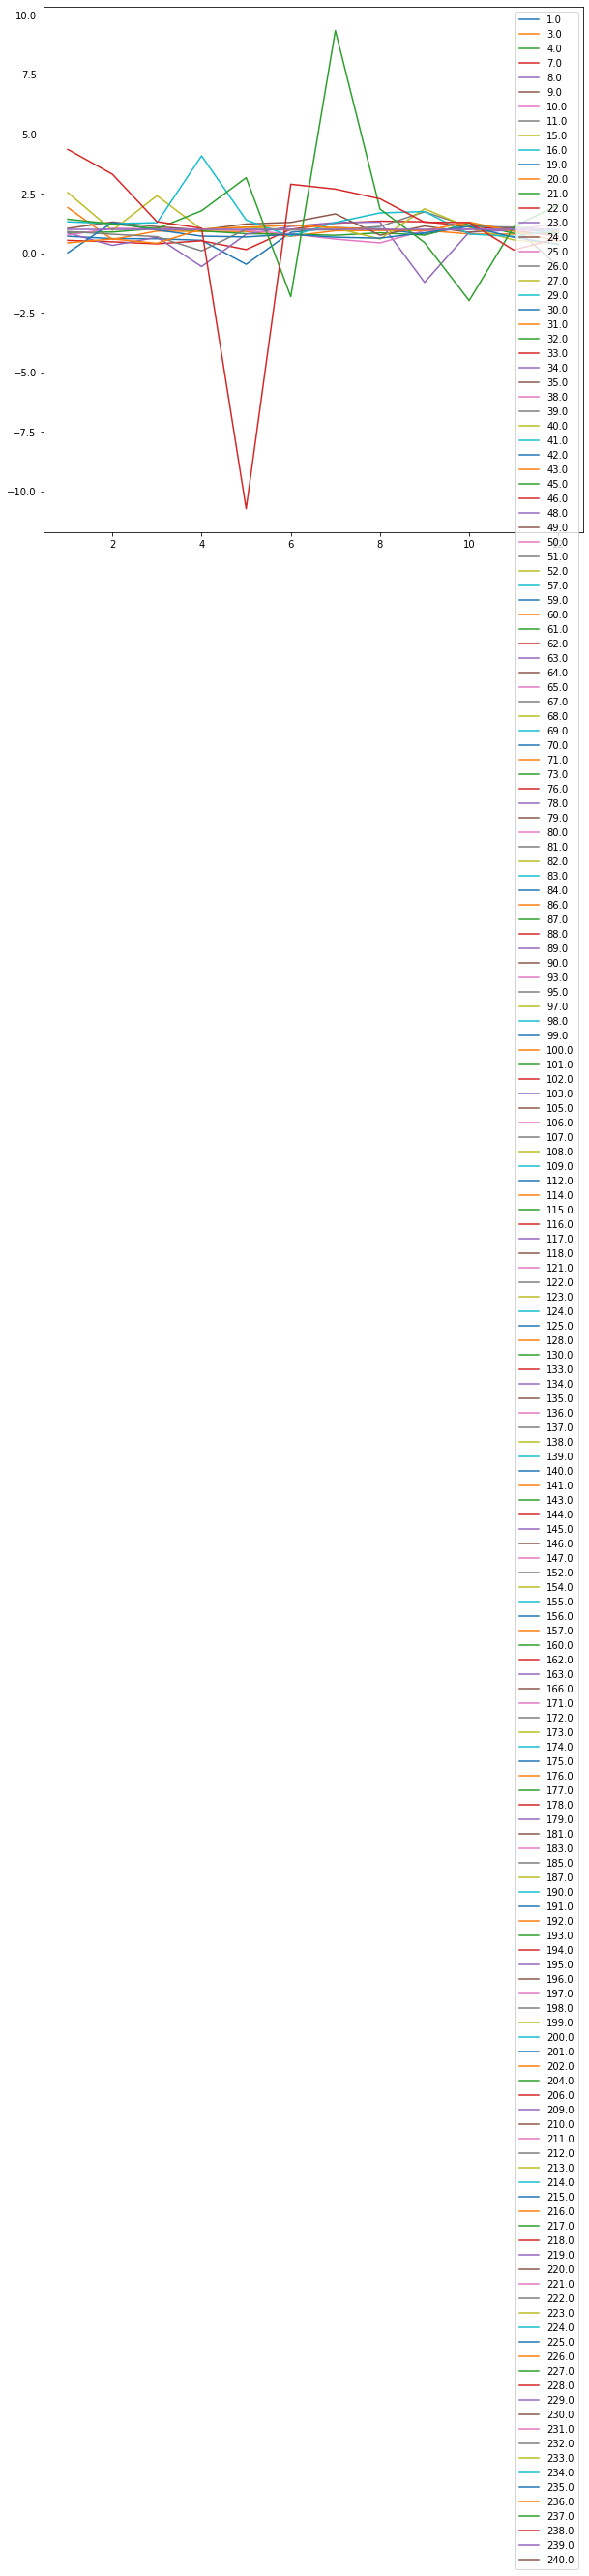

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
df.groupby(df.index.month).mean().plot(ax=ax)

In [10]:
# Filter:
df[df < 0] = np.nan
df[df > 10] = np.nan

In [11]:
df = df.dropna(axis=1, how='all')

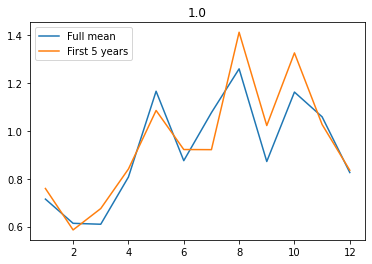

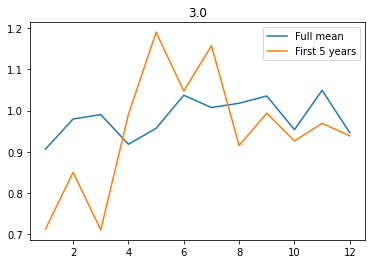

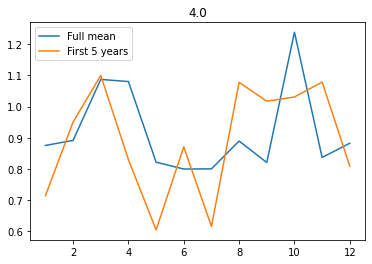

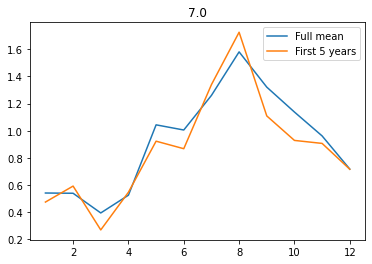

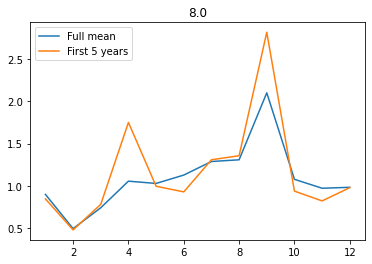

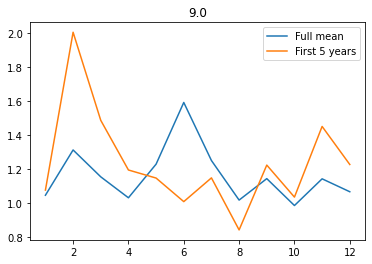

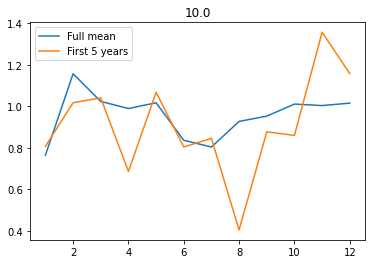

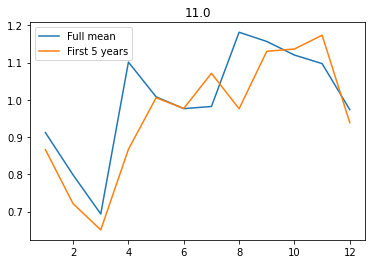

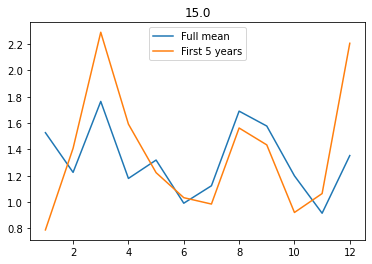

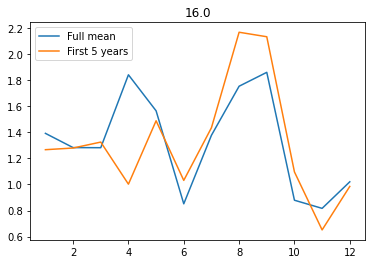

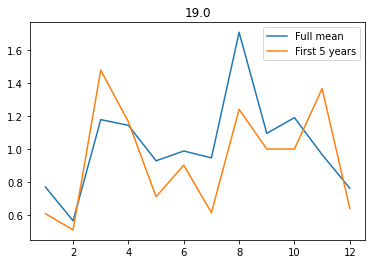

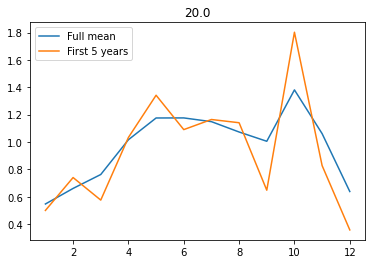

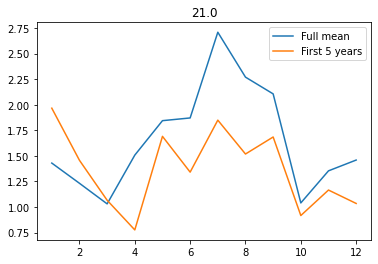

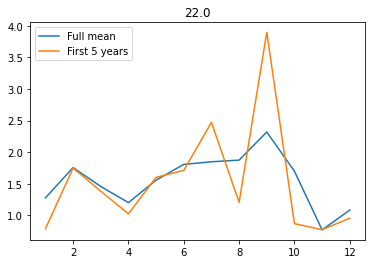

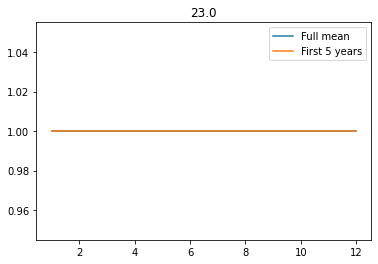

In [11]:
for k in df.columns:
    plt.figure()
    plt.title(k)
    df[k].groupby(df.index.month).mean().plot(label='Full mean')
    short_df = df[df.index.year < 2005]
    short_df[k].groupby(short_df.index.month).mean().plot(label='First 5 years')
    plt.errorbar(y=df[k].groupby(df.index.month).std())
    plt.legend()